Epoch 1/20, Loss = 1.9804
Epoch 2/20, Loss = 0.5991
Epoch 3/20, Loss = 0.5069
Epoch 4/20, Loss = 0.3669
Epoch 5/20, Loss = 0.2014
Epoch 6/20, Loss = 0.1493
Epoch 7/20, Loss = 0.1284
Epoch 8/20, Loss = 0.0971
Epoch 9/20, Loss = 0.0794
Epoch 10/20, Loss = 0.0731
Epoch 11/20, Loss = 0.0741
Epoch 12/20, Loss = 0.0661
Epoch 13/20, Loss = 0.0661
Epoch 14/20, Loss = 0.0607
Epoch 15/20, Loss = 0.0626
Epoch 16/20, Loss = 0.0590
Epoch 17/20, Loss = 0.0555
Epoch 18/20, Loss = 0.0597
Epoch 19/20, Loss = 0.0548
Epoch 20/20, Loss = 0.0546


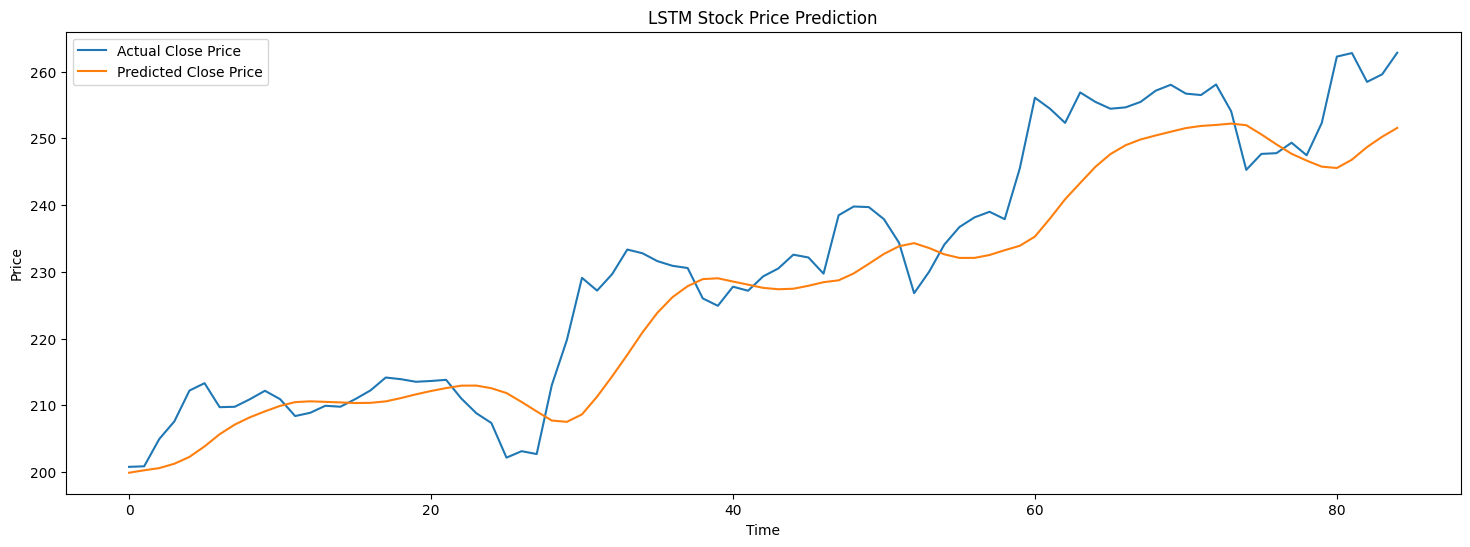

In [2]:
import numpy as np
import pandas as pd
import torch
import torch.nn as nn
from torch.utils.data import Dataset, DataLoader
from sklearn.preprocessing import MinMaxScaler
import matplotlib.pyplot as plt


df = pd.read_excel("/workspaces/Independent_study_Time_series_analysis/AAPL_two_years.xlsx")
df['Date'] = pd.to_datetime(df['Date'])
df = df.sort_values("Date")
df = df.dropna(subset=["Close"])


close_prices = df[['Close']].values

# =====================
# Scaling
# =====================
scaler = MinMaxScaler()
scaled_close = scaler.fit_transform(close_prices)

# =====================
# Create Sequences
# =====================
SEQ_LEN = 60

def create_sequences(data, seq_len):
    X, y = [], []
    for i in range(len(data) - seq_len):
        X.append(data[i:i+seq_len])
        y.append(data[i+seq_len])
    return np.array(X), np.array(y)

X, y = create_sequences(scaled_close, SEQ_LEN)

# =====================
# Train/Test Split
# =====================
train_size = int(0.8 * len(X))
X_train, X_test = X[:train_size], X[train_size:]
y_train, y_test = y[:train_size], y[train_size:]

X_train = torch.tensor(X_train, dtype=torch.float32)
X_test  = torch.tensor(X_test, dtype=torch.float32)
y_train = torch.tensor(y_train, dtype=torch.float32)
y_test  = torch.tensor(y_test, dtype=torch.float32)

# =====================
# Dataset & Dataloader
# =====================
class StockDataset(Dataset):
    def __init__(self, X, y):
        self.X = X
        self.y = y

    def __len__(self):
        return len(self.X)

    def __getitem__(self, idx):
        return self.X[idx], self.y[idx]

train_loader = DataLoader(StockDataset(X_train, y_train), batch_size=32, shuffle=True)

# =====================
# LSTM Model
# =====================
class LSTMModel(nn.Module):
    def __init__(self, input_size=1, hidden_size=64, num_layers=2, output_size=1):
        super().__init__()
        self.lstm = nn.LSTM(input_size, hidden_size, num_layers, batch_first=True)
        self.fc = nn.Linear(hidden_size, output_size)

    def forward(self, x):
        out, _ = self.lstm(x)
        out = out[:, -1, :]
        out = self.fc(out)
        return out

model = LSTMModel()
criterion = nn.MSELoss()
optimizer = torch.optim.Adam(model.parameters(), lr=0.001)

# =====================
# Training Loop
# =====================
EPOCHS = 20
for epoch in range(EPOCHS):
    model.train()
    epoch_loss = 0

    for X_batch, y_batch in train_loader:
        optimizer.zero_grad()
        y_pred = model(X_batch)
        loss = criterion(y_pred, y_batch)
        loss.backward()
        optimizer.step()
        epoch_loss += loss.item()

    print(f"Epoch {epoch+1}/{EPOCHS}, Loss = {epoch_loss:.4f}")

# =====================
# Prediction on Test Data
# =====================
model.eval()
with torch.no_grad():
    preds = model(X_test).numpy()

preds = scaler.inverse_transform(preds)
actual = scaler.inverse_transform(y_test.numpy())

# =====================
# Plot Results
# =====================
plt.figure(figsize=(18,6))
plt.plot(actual, label="Actual Close Price")
plt.plot(preds, label="Predicted Close Price")
plt.title("LSTM Stock Price Prediction")
plt.xlabel("Time")
plt.ylabel("Price")
plt.legend()
plt.show()
